In [1]:
import numpy as np
import pandas as pd
import os
import datetime
os.getcwd()

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import (
    accuracy_score,
    ConfusionMatrixDisplay,
    mean_squared_error,
    precision_score,
    recall_score,
    RocCurveDisplay
)

In [2]:
projectdf = pd.read_csv('NewMemYear.csv')
projectdf2 = pd.read_csv('NewMemYear.csv')
conditionsdf = pd.read_csv('Conditions_ohc.csv')
chemo_pats = pd.read_csv('chemo_pats.csv')

In [3]:
conditionsdrop_list = ['DeceasedFlag', 'CHEMO', 'Alcoholism', 'Anemia (disorder)',
       'Blindness due to type 2 diabetes mellitus (disorder)',
       'Body mass index 30+ - obesity (finding)',
       'Body mass index 40+ - severely obese (finding)',
       'Chronic kidney disease stage 1 (disorder)',
       'Chronic kidney disease stage 2 (disorder)',
       'Chronic obstructive bronchitis (disorder)', 'Diabetes',
       'Diabetic retinopathy associated with type II diabetes mellitus (disorder)',
       'Hyperglycemia (disorder)', 'Hyperlipidemia', 'Hypertension',
       'Hypertriglyceridemia (disorder)', 'Lupus erythematosus',
       'Macular edema and retinopathy due to type 2 diabetes mellitus (disorder)',
       'Metabolic syndrome X (disorder)',
       'Microalbuminuria due to type 2 diabetes mellitus (disorder)',
       'Neuropathy due to type 2 diabetes mellitus (disorder)',
       'Nonproliferative diabetic retinopathy due to type 2 diabetes mellitus (disorder)',
       'Opioid abuse (disorder)', 'Prediabetes',
       'Primary fibromyalgia syndrome',
       'Proliferative diabetic retinopathy due to type II diabetes mellitus (disorder)',
       'Pulmonary emphysema (disorder)', 'Rheumatoid arthritis',
       'Shock (disorder)', 'Stroke', 'Chronic congestive heart failure (disorder)', 'Atrial Fibrillation',
       'Cardiac Arrest', 'Coronary Heart Disease',
       'History of cardiac arrest (situation)',
       'History of myocardial infarction (situation)', 'Myocardial Infarction', 'Cardiac Event', 'Unnamed: 0', 'Age']

In [4]:
# Looking at specific chemo drugs -- this code creates dummies for them and groups by patient
chemo_ohc = chemo_pats[['PATIENT']].join(pd.get_dummies(chemo_pats['DESCRIPTION'])).groupby('PATIENT').max()

In [5]:
# Drop some columns
projectdf.drop(['MemYear', 'emergency', 'inpatient', 'outpatient', 'urgentcare', 'wellness', 'ER_Visits', 'Inpt_Admits'], axis=1, inplace=True)

In [6]:
cancer_list = ['Carcinoma in situ of prostate (disorder)',
       'Malignant neoplasm of breast (disorder)', 'Malignant tumor of colon',
       'Metastasis from malignant tumor of prostate (disorder)',
       'Neoplasm of prostate',
       'Non-small cell carcinoma of lung  TNM stage 1 (disorder)',
       'Non-small cell lung cancer (disorder)',
       'Primary malignant neoplasm of colon',
       'Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)',
       'Secondary malignant neoplasm of colon',
       'Suspected lung cancer (situation)']

# New df to attempt date calculations
dateattempt = projectdf2[projectdf2[cancer_list].any(axis=1)]
dateattempt2 = projectdf2[projectdf2['Chronic congestive heart failure (disorder)']==True]

# Query first and last years for any cancer column containing a true value and caluculate difference
date2 = dateattempt.groupby('PATIENT').agg(CAFirstYear=('MemYear', 'min'), CALastYear=('MemYear', 'max'))
date2['CADuration'] = date2['CALastYear']-date2['CAFirstYear']

# Query first year CHF column contains a true value and caluculate difference from initial cancer diagnosis
chfdate = dateattempt2.groupby('PATIENT').agg(CHFDiagnosisYear=('MemYear', 'min'))
chfdate['DelaytoCHF']=chfdate['CHFDiagnosisYear']-date2['CAFirstYear']


In [7]:
#There are no values less than zero in the CHF time to diagnosis. 
chfdate[chfdate['DelaytoCHF']<1].any()

CHFDiagnosisYear    False
DelaytoCHF          False
dtype: bool

In [8]:
# Group all the patient info into one line for each patient
projectdf = projectdf.groupby('PATIENT').max()

In [9]:
# Add the one hot encoded chemo drugs to the conditions df.
projectdf = projectdf.join(chemo_ohc, on='PATIENT', how = 'left')

In [10]:
# Join timeline dfs to main df
projectdf = projectdf.join(date2['CADuration'], on='PATIENT', how='left')

In [11]:
#projectdf=projectdf.reset_index().drop(['Unnamed: 0'], axis=1)

In [12]:
# Assess for null values and fill null conditions with '0'
projectdf.isnull().sum()
projectdf.fillna(0, inplace=True)

In [13]:
Y = projectdf['Chronic congestive heart failure (disorder)']
# X = projectdf.drop(['Chronic congestive heart failure (disorder)', 'Atrial Fibrillation',
#        'Cardiac Arrest', 'Coronary Heart Disease',
#        'History of cardiac arrest (situation)',
#        'History of myocardial infarction (situation)', 'Myocardial Infarction', 'Cardiac Event', "Unnamed: 0", 'Age'], axis=1)
X = projectdf.drop(conditionsdrop_list, axis=1).drop(cancer_list, axis=1).drop(['ISMALE', 'ISMARRIED', 'ISHISPANIC', 'asian', 'black', 'other', 'white', 'CADuration'], axis=1)
#X = projectdf.drop(conditionsdrop_list, axis=1).drop(chemo_ohc, axis=1).drop(['ISMALE', 'ISMARRIED', 'ISHISPANIC', 'asian', 'black', 'other', 'white'], axis=1)

In [41]:
Demographics = projectdf.drop(conditionsdrop_list, axis=1).drop(cancer_list, axis=1).drop(chemo_ohc, axis=1)


(514, 8)

In [47]:
Demographics.sum()

ISMALE         413
ISMARRIED      413
ISHISPANIC      36
asian           31
black           54
other            0
white          429
CADuration    4794
dtype: int64

In [44]:
Demographics['CADuration'].mean()

9.326848249027238

In [14]:
# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [15]:

# Create a random forest model with cross validation values
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)
rfc.get_params()

param_grid = {
            'max_depth': [2, 3, 4, 5],
            'n_estimators': [5, 10, 15, 25, 50],
            'n_jobs': [-1],
            }

cv = KFold(n_splits=5)

cv_mod = GridSearchCV(rfc, param_grid=param_grid, cv=cv)


In [16]:
# Fit model and get best parameters
gridcv = cv_mod.fit(X_train, Y_train)
gridcv.best_params_

{'max_depth': 3, 'n_estimators': 10, 'n_jobs': -1}

In [17]:
# A list of features used
X_train.columns

Index(['0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe',
       '1 ML DOCEtaxel 20 MG/ML Injection',
       '10 ML Doxorubicin Hydrochloride 2 MG/ML Injection',
       '10 ML oxaliplatin 5 MG/ML Injection',
       '100 ML Epirubicin Hydrochloride 2 MG/ML Injection',
       'Cisplatin 50 MG Injection', 'Etoposide 100 MG Injection',
       'Methotrexate 2.5 MG Oral Tablet', 'PACLitaxel 100 MG Injection',
       'Paclitaxel 100 MG Injection', 'Tamoxifen 10 MG Oral Tablet',
       'exemestane 25 MG Oral Tablet', 'neratinib 40 MG Oral Tablet',
       'palbociclib 100 MG Oral Capsule', 'ribociclib 200 MG Oral Tablet'],
      dtype='object')

In [18]:
# Identify most relevant features in the set
most_relevant_features = [gridcv.best_estimator_.estimators_[i].feature_importances_.argmax()
                          for i in range(len(gridcv.best_estimator_.estimators_))]
X_train.columns[most_relevant_features]

Index(['1 ML DOCEtaxel 20 MG/ML Injection',
       '1 ML DOCEtaxel 20 MG/ML Injection',
       '10 ML oxaliplatin 5 MG/ML Injection',
       '0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe',
       '10 ML oxaliplatin 5 MG/ML Injection',
       '10 ML oxaliplatin 5 MG/ML Injection', 'PACLitaxel 100 MG Injection',
       '0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe',
       '0.25 ML Leuprolide Acetate 30 MG/ML Prefilled Syringe',
       '1 ML DOCEtaxel 20 MG/ML Injection'],
      dtype='object')

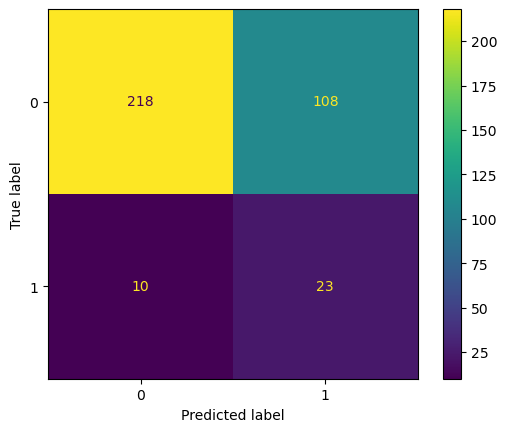

In [19]:
# Confusion matrix for the training set
_ = ConfusionMatrixDisplay.from_estimator(gridcv.best_estimator_, X_train, Y_train)

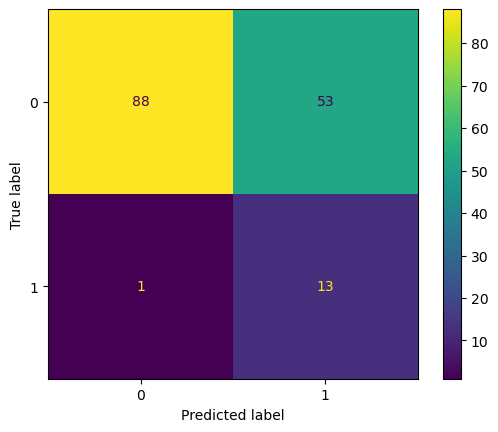

In [20]:
# Confusion matrix for the test set
_ = ConfusionMatrixDisplay.from_estimator(gridcv.best_estimator_, X_test, Y_test)

In [21]:
accuracy_score(Y_train, gridcv.best_estimator_.predict(X_train))

0.6713091922005571

In [22]:
precision_score(Y_train, gridcv.best_estimator_.predict(X_train))

0.17557251908396945

In [23]:
recall_score(Y_train, gridcv.best_estimator_.predict(X_train))

0.696969696969697

In [24]:
accuracy_score(Y_test, gridcv.best_estimator_.predict(X_test))

0.6516129032258065

In [25]:
precision_score(Y_test, gridcv.best_estimator_.predict(X_test))

0.19696969696969696

In [26]:
recall_score(Y_test, gridcv.best_estimator_.predict(X_test))

0.9285714285714286

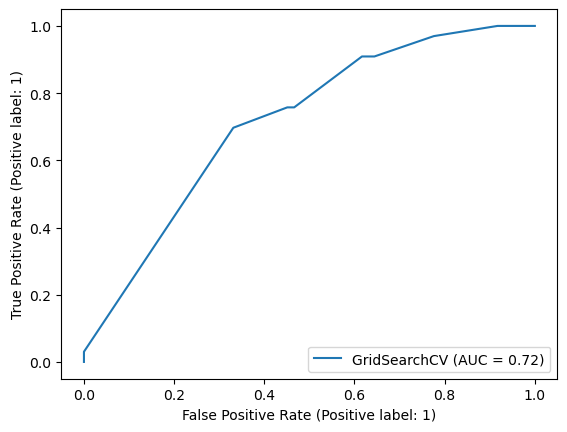

In [27]:
# ROCAUC  for the training set
_ = RocCurveDisplay.from_estimator(gridcv, X_train, Y_train)

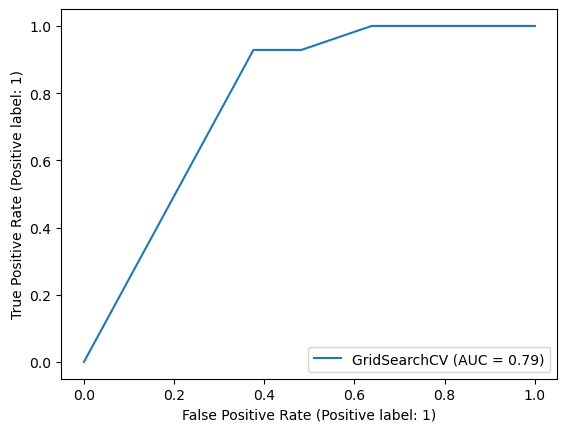

In [28]:
# ROCAUC  for the test set
_ = RocCurveDisplay.from_estimator(gridcv, X_test, Y_test)